In [63]:
import yfinance as yf
import pandas as pd

In [64]:
sp500 = yf.Ticker("AMZN")
df = pd.DataFrame(sp500.history(period="max"))

In [65]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1997-05-15 00:00:00-04:00,0.121875,0.125000,0.096354,0.097917,1443120000,0.0,0.0
1997-05-16 00:00:00-04:00,0.098438,0.098958,0.085417,0.086458,294000000,0.0,0.0
1997-05-19 00:00:00-04:00,0.088021,0.088542,0.081250,0.085417,122136000,0.0,0.0
1997-05-20 00:00:00-04:00,0.086458,0.087500,0.081771,0.081771,109344000,0.0,0.0
1997-05-21 00:00:00-04:00,0.081771,0.082292,0.068750,0.071354,377064000,0.0,0.0


<Axes: xlabel='Date'>

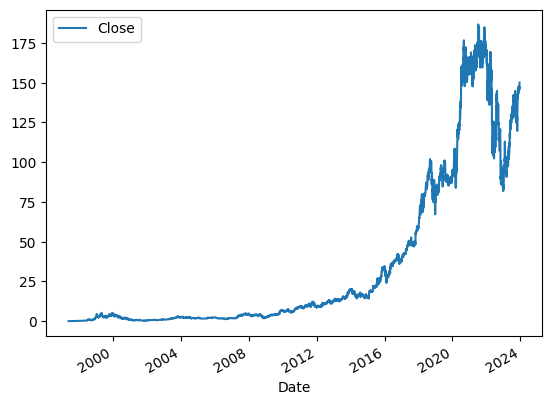

In [66]:
df.plot.line(y="Close", use_index=True)

Data Cleaning

In [67]:
# Removing unnecessary columns
del df["Dividends"]
del df["Stock Splits"]

In [68]:
df["Tomorrow"] = df["Close"].shift(-1)
df["Target"] = (df["Tomorrow"] > df["Close"]).astype(int)

In [69]:
df = df.loc["1990-01-01":].copy()

In [70]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = df.iloc[:-100]  # train on all rows besides last 100 rows
test = df.iloc[-100:]  # test on last 100 rows

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"]) # using predictor columns to predict target



RandomForestClassifier(min_samples_split=100, random_state=1)

Measure accuracy of model

In [71]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
preds

Date
2023-07-27 00:00:00-04:00    0
2023-07-28 00:00:00-04:00    0
2023-07-31 00:00:00-04:00    1
2023-08-01 00:00:00-04:00    0
2023-08-02 00:00:00-04:00    1
                            ..
2023-12-11 00:00:00-05:00    0
2023-12-12 00:00:00-05:00    0
2023-12-13 00:00:00-05:00    0
2023-12-14 00:00:00-05:00    0
2023-12-15 00:00:00-05:00    1
Length: 100, dtype: int64

In [72]:
precision_score(test["Target"], preds)

0.5882352941176471

<Axes: xlabel='Date'>

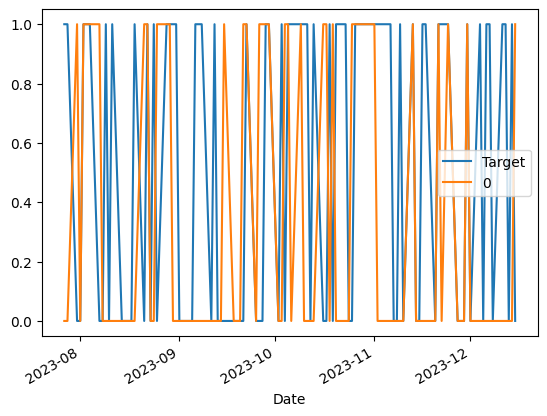

In [73]:
combined = pd.concat([test["Target"],preds], axis=1)
combined.plot()

In [74]:
# Backtesting: better way to test algorithm. We're only testing against last 100 days now
def predict(train, test, predictors, model):
  model.fit(train[predictors], train["Target"])  # fitting of model
  preds = model.predict(test[predictors])# generating predictions
  preds = pd.Series(preds, index=test.index, name="Predictions")# putting predictions into Series
  combined = pd.concat([test["Target"], preds], axis=1)# combining everything together
  return combined

In [75]:
def backtest(data, model, predictors, start=2500, step=250):
  all_predictions = [] # list of all predictions
  for i in range(start, data.shape[0], step):
    train = data.iloc[0:i].copy() # training data
    test = data.iloc[i:(i+step)].copy() # testing data
    predictions = predict(train, test, predictors, model)
    all_predictions.append(predictions)
  return pd.concat(all_predictions)

In [76]:
predictions = backtest(df, model, predictors)

In [77]:
predictions["Predictions"].value_counts()

Predictions
0    3282
1     910
Name: count, dtype: int64

In [78]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5197802197802198

In [79]:
# baseline
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.520754
0    0.479246
Name: count, dtype: float64

In [80]:
# add more predictors to model
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
  rolling_averages = df.rolling(horizon).mean()

  ratio_column = f"Close_Ratio_{horizon}"
  df[ratio_column] = df["Close"] / rolling_averages["Close"]

  trend_column = f"Trend_{horizon}"
  df[trend_column] = df.shift(1).rolling(horizon).sum()["Target"]

  new_predictors += [ratio_column, trend_column]

df = df.dropna()
df

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
2001-05-03 00:00:00-04:00,0.841500,0.850000,0.812500,0.837500,100200000,0.878000,1,0.989368,1.0,1.023839,3.0,1.335100,27.0,0.580388,115.0,0.481837,478.0
2001-05-04 00:00:00-04:00,0.817500,0.880000,0.796500,0.878000,131690000,0.846000,0,1.023608,1.0,1.044119,4.0,1.394919,28.0,0.611715,116.0,0.504908,479.0
2001-05-07 00:00:00-04:00,0.868000,0.876500,0.825500,0.846000,101674000,0.809000,0,0.981439,1.0,0.992608,3.0,1.339566,28.0,0.592668,115.0,0.486294,479.0
2001-05-08 00:00:00-04:00,0.814000,0.824500,0.780000,0.809000,143830000,0.750500,0,0.977644,0.0,0.957170,2.0,1.276256,28.0,0.569712,115.0,0.464831,479.0
2001-05-09 00:00:00-04:00,0.777500,0.783000,0.750000,0.750500,93420000,0.731000,0,0.962488,0.0,0.910580,1.0,1.183175,27.0,0.531499,114.0,0.431050,479.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-08 00:00:00-05:00,145.479996,147.839996,145.399994,147.419998,41858000,145.889999,0,1.001835,2.0,1.008980,3.0,1.083920,32.0,1.252116,136.0,1.078812,521.0
2023-12-11 00:00:00-05:00,145.660004,146.190002,143.639999,145.889999,50907300,147.479996,1,0.994784,1.0,0.997075,3.0,1.071948,32.0,1.236795,135.0,1.067176,520.0
2023-12-12 00:00:00-05:00,145.520004,147.500000,145.300003,147.479996,44944300,148.839996,1,1.005420,1.0,1.007116,3.0,1.082637,33.0,1.247948,135.0,1.078348,521.0


In [81]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

def predict(train, test, predictors, model):
  model.fit(train[predictors], train["Target"])  # fitting of model
  preds = model.predict_proba(test[predictors])[:,1]# generating predictions
  preds[preds >= 0.6] = 1
  preds[preds < 0.6] = 0
  preds = pd.Series(preds, index=test.index, name="Predictions")# putting predictions into Series
  combined = pd.concat([test["Target"], preds], axis=1)# combining everything together
  return combined

In [82]:
predictions = backtest(df, model, new_predictors)

In [83]:
predictions["Predictions"].value_counts()

Predictions
0.0    3027
1.0     164
Name: count, dtype: int64

In [84]:
precision_score(predictions["Target"], predictions["Predictions"])

0.524390243902439